In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

df = pd.read_csv('Hitters.csv')
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
df.isnull().sum()


,0
AtBat,0
Hits,0
HmRun,0
Runs,0
RBI,0
Walks,0
Years,0
CAtBat,0
CHits,0
CHmRun,0


In [5]:
df.dropna(inplace=True)

Part I: Different Model Specs

A. Regression without regularization

In [8]:
X = df.drop(columns=['Salary'])
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['League', 'Division', 'NewLeague']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse}")

cross_val_mse = -cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_cross_val_mse = cross_val_mse.mean()
print(f"Estimated MSE from cross-validation: {mean_cross_val_mse}")

coefs = pipeline.named_steps['regression'].coef_

feature_names = numeric_features + list(
    pipeline.named_steps['preprocessor']
    .transformers_[1][1]  #Reccomended by ChatGPT - Access the OneHotEncoder in the "cat" transformer
    .get_feature_names_out(categorical_features)  # Get dummy variable names
)

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

print("Feature Coefficients:")
print(coefs_df)


Test MSE: 118171.48028569469
Estimated MSE from cross-validation: 121136.31031816886
Feature Coefficients:
        Feature  Coefficient
0         AtBat  -384.625311
1          Hits   369.843335
2         HmRun    42.890180
3          Runs   -29.301448
4           RBI   -15.381813
5         Walks   130.131350
6         Years   -11.145178
7        CAtBat  -258.068451
8         CHits   -13.517868
9        CHmRun     7.929418
10        CRuns   460.993036
11         CRBI   271.125959
12       CWalks  -255.193512
13      PutOuts    76.364714
14      Assists   109.351063
15       Errors   -62.294005
16     League_N    43.337925
17   Division_W  -109.048644
18  NewLeague_N    19.141294


Above we can see the test MSE and cross validation MSE. As expected, hits, home runs, walks, putouts, and assists all have a positive effect on the salary. However, it is interesting that career walks is drastically negative. This could be due to the fact that older players generally do not make as much money as players in their prime. It is also interesting that runs is negative and it could potentially be due to an outlier in the sample.

B. Ridge regression

In [21]:
X = df.drop(columns=['Salary'])
y = df['Salary']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['League', 'Division', 'NewLeague']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

param_grid = {'ridge__alpha': [0.001, .01, .1, 1.0, 10]}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Best alpha: {best_alpha}")

ridge_pipeline.set_params(ridge__alpha=best_alpha)
ridge_pipeline.fit(X, y)

cross_val_mse = -cross_val_score(ridge_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_cross_val_mse = cross_val_mse.mean()
print(f"Estimated MSE from cross-validation: {mean_cross_val_mse}")

coefs = ridge_pipeline.named_steps['ridge'].coef_
feature_names = numeric_features + list(
    ridge_pipeline.named_steps['preprocessor']
    .transformers_[1][1].get_feature_names_out(categorical_features)
)
coefs_df2 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

print(coefs_df2)


Best alpha: 1.0
Estimated MSE from cross-validation: 119034.33271954516
        Feature  Coefficient
0         AtBat  -271.088165
1          Hits   296.801967
2         HmRun    17.973971
3          Runs   -29.212352
4           RBI    -8.909304
5         Walks   124.344012
6         Years   -38.619131
7        CAtBat  -225.511649
8         CHits   126.210585
9        CHmRun    39.055346
10        CRuns   320.802717
11         CRBI   160.409497
12       CWalks  -184.289408
13      PutOuts    78.651037
14      Assists    47.493631
15       Errors   -23.651303
16     League_N    58.555947
17   Division_W  -119.076927
18  NewLeague_N   -24.027205


These coefficients follow a similar trend to the ones in the linear model made above, but the values are slightly less on average. Hits still have a huge positive impact on salary.

C. Lasso Regression

In [24]:
X = df.drop(columns=['Salary'])
y = df['Salary']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['League', 'Division', 'NewLeague']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['lasso__alpha']
print(f"Best alpha: {best_alpha}")

lasso_pipeline.set_params(lasso__alpha=best_alpha)
lasso_pipeline.fit(X, y)

cross_val_mse = -cross_val_score(lasso_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_cross_val_mse = cross_val_mse.mean()
print(f"Estimated MSE from cross-validation: {mean_cross_val_mse}")

coefs = lasso_pipeline.named_steps['lasso'].coef_

feature_names = numeric_features + list(
    lasso_pipeline.named_steps['preprocessor']
    .transformers_[1][1].get_feature_names_out(categorical_features)
)

coefs_df3 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
print("All Coefficients:")
print(coefs_df3)


Best alpha: 1
Estimated MSE from cross-validation: 119758.22781528861
All Coefficients:
        Feature  Coefficient
0         AtBat  -282.369623
1          Hits   304.358267
2         HmRun    11.127146
3          Runs   -24.966048
4           RBI    -0.000000
5         Walks   120.694778
6         Years   -34.947507
7        CAtBat  -162.644108
8         CHits     0.000000
9        CHmRun    14.222855
10        CRuns   375.565034
11         CRBI   192.616442
12       CWalks  -189.643123
13      PutOuts    78.760260
14      Assists    41.996661
15       Errors   -18.479421
16     League_N    35.826079
17   Division_W  -114.412953
18  NewLeague_N    -0.000000


Most of these values are considered significant in the lasso regression. Hits are still a very positive indicator for salary - when you move one standard deviation up for hits it increases salary by about 304,000 dollars.

D. Elastic Net

In [27]:
X = df.drop(columns=['Salary'])
y = df['Salary']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['League', 'Division', 'NewLeague']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet(max_iter=10000))
])

param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'elasticnet__l1_ratio': [0.2, 0.5, 0.7, 1.0]
}
grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['elasticnet__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet__l1_ratio']
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

elastic_net_pipeline.set_params(elasticnet__alpha=best_alpha, elasticnet__l1_ratio=best_l1_ratio)
elastic_net_pipeline.fit(X, y)

cross_val_mse = -cross_val_score(elastic_net_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_cross_val_mse = cross_val_mse.mean()
print(f"Estimated MSE from cross-validation: {mean_cross_val_mse}")

coefs = elastic_net_pipeline.named_steps['elasticnet'].coef_

feature_names = numeric_features + list(
    elastic_net_pipeline.named_steps['preprocessor']
    .transformers_[1][1].get_feature_names_out(categorical_features)
)

coefs_df4 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

print("Elastic Net Regression Coefficients:")
print(coefs_df4)


Best alpha: 0.01
Best l1_ratio: 0.2
Estimated MSE from cross-validation: 118836.721720832
Elastic Net Regression Coefficients:
        Feature  Coefficient
0         AtBat  -245.451667
1          Hits   263.336250
2         HmRun     8.140293
3          Runs   -12.156781
4           RBI    -0.289557
5         Walks   115.329254
6         Years   -47.370131
7        CAtBat  -145.399014
8         CHits   124.944236
9        CHmRun    52.957120
10        CRuns   249.017422
11         CRBI   130.086701
12       CWalks  -163.955062
13      PutOuts    78.243963
14      Assists    43.125053
15       Errors   -24.381416
16     League_N    54.656435
17   Division_W  -119.349269
18  NewLeague_N   -21.361083


This provides a combination of the two above and has even smaller coefficients. The same trends are appearing for the coefficients as the models before.

Part II. Variable Selection

The most important variable seems to be career runs due to its bery high values in all of the models. On average, it has the biggest value out of all the variables.

In [29]:
X = df[['CRuns']]
y = df['Salary']

# ChatGPT recommended a function to streamline the process for each model
def evaluate_model(model, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    best_mse = -grid_search.best_score_
    best_params = grid_search.best_params_
    return best_mse, best_params

ridge = Ridge()
ridge_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
ridge_mse, ridge_best_params = evaluate_model(ridge, ridge_param_grid)

lasso = Lasso(max_iter=10000)
lasso_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
lasso_mse, lasso_best_params = evaluate_model(lasso, lasso_param_grid)

elasticnet = ElasticNet(max_iter=10000)
elasticnet_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'model__l1_ratio': [0.2, 0.5, 0.7, 1.0]
}
elasticnet_mse, elasticnet_best_params = evaluate_model(elasticnet, elasticnet_param_grid)

linear = LinearRegression()
linear_mse, linear_best_params = evaluate_model(linear, {})

results_df = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "ElasticNet", "LinearRegression"],
    "MSE": [ridge_mse, lasso_mse, elasticnet_mse, linear_mse],
    "Best Params": [ridge_best_params, lasso_best_params, elasticnet_best_params, linear_best_params]
})

results_df = results_df.sort_values(by="MSE").reset_index(drop=True)

print("Model Comparison CRuns")
print(results_df)


Model Comparison CRuns
              Model            MSE  \
0        ElasticNet  143655.076048   
1             Ridge  143658.517369   
2             Lasso  143793.449159   
3  LinearRegression  143812.935916   

                                     Best Params  
0  {'model__alpha': 0.1, 'model__l1_ratio': 0.5}  
1                           {'model__alpha': 10}  
2                           {'model__alpha': 10}  
3                                             {}  


This model is not a great predictor and we can tell that more variables need to be added. The elasticNet model performed the best with CRuns as the only predictor variable.

The five best variables are CRuns, Hits, CRBI, AtBat, and CWalks due to these having the largest (positive or negative) values.

In [31]:
X = df[['CRuns', 'Hits', 'CRBI', 'AtBat', 'CWalks']]
y = df['Salary']

ridge = Ridge()
ridge_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
ridge_mse, ridge_best_params = evaluate_model(ridge, ridge_param_grid)

lasso = Lasso(max_iter=10000)
lasso_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
lasso_mse, lasso_best_params = evaluate_model(lasso, lasso_param_grid)

elasticnet = ElasticNet(max_iter=10000)
elasticnet_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'model__l1_ratio': [0.2, 0.5, 0.7, 1.0]
}
elasticnet_mse, elasticnet_best_params = evaluate_model(elasticnet, elasticnet_param_grid)

linear = LinearRegression()
linear_mse, linear_best_params = evaluate_model(linear, {})  # ChatGPT recommended an empty dictionary due to there being no alpha or l1 ratio

results_df = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "ElasticNet", "LinearRegression"],
    "MSE": [ridge_mse, lasso_mse, elasticnet_mse, linear_mse],
    "Best Params": [ridge_best_params, lasso_best_params, elasticnet_best_params, linear_best_params]
})

results_df2 = results_df.sort_values(by="MSE").reset_index(drop=True)

print("Model Comparison Using 5 Best Variables")
print(results_df2)


Model Comparison Using 5 Best Variables
              Model            MSE  \
0        ElasticNet  125024.904648   
1             Ridge  125142.787641   
2             Lasso  125289.894263   
3  LinearRegression  125502.852876   

                                      Best Params  
0  {'model__alpha': 0.01, 'model__l1_ratio': 0.2}  
1                           {'model__alpha': 1.0}  
2                           {'model__alpha': 1.0}  
3                                              {}  


The fit does not seem to be as good as the model with all the predictor variables, but the MSE has gone down from the one variable model and the ElasticNet model still is performing the best.

Using the 5 best variables and their interaction with the best categorical variable (Division_W)

In [40]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV

# Manually add the Division_W for simplicity
df['Division_W'] = (df['Division'] == 'W').astype(int)

numeric_vars = ['CRuns', 'Hits', 'CRBI', 'AtBat', 'CWalks']

X = df[numeric_vars].copy()

# ChatGPT recommended this method instead of polynomial features to keep Division_W by itself out of the model
for var in numeric_vars:
    X[f"{var}_Division_W"] = X[var] * df['Division_W']

y = df['Salary']

def evaluate_model_with_interactions(model, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    best_mse = -grid_search.best_score_
    best_params = grid_search.best_params_
    return best_mse, best_params

ridge = Ridge()
ridge_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
ridge_mse, ridge_best_params = evaluate_model_with_interactions(ridge, ridge_param_grid)

lasso = Lasso(max_iter=10000)
lasso_param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]}
lasso_mse, lasso_best_params = evaluate_model_with_interactions(lasso, lasso_param_grid)

elasticnet = ElasticNet(max_iter=10000)
elasticnet_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'model__l1_ratio': [0.2, 0.5, 0.7, 1.0]
}
elasticnet_mse, elasticnet_best_params = evaluate_model_with_interactions(elasticnet, elasticnet_param_grid)

linear = LinearRegression()
linear_mse, linear_best_params = evaluate_model_with_interactions(linear, {})

results_df = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "ElasticNet", "LinearRegression"],
    "MSE": [ridge_mse, lasso_mse, elasticnet_mse, linear_mse],
    "Best Params": [ridge_best_params, lasso_best_params, elasticnet_best_params, linear_best_params]
})

results_df3 = results_df.sort_values(by="MSE").reset_index(drop=True)

print("Model Comparison Results Using Best Numeric Predictors and Interaction Terms with Division_W (Sorted by MSE):")
print(results_df3)




Model Comparison Results Using Best Numeric Predictors and Interaction Terms with Division_W (Sorted by MSE):
              Model            MSE  \
0        ElasticNet  121726.958002   
1             Ridge  122389.920071   
2             Lasso  123890.244556   
3  LinearRegression  131637.234537   

                                     Best Params  
0  {'model__alpha': 0.1, 'model__l1_ratio': 0.2}  
1                           {'model__alpha': 10}  
2                           {'model__alpha': 10}  
3                                             {}  


Part III. Discussion

A.
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The ridge models had lower MSE than the linear models and seemed to make closer predictions. The coefficients tend to be smaller for the ridge models. This makes sense because Ridge adds a penalty lowering coefficients toward 0. The penalty helps with overfitting so it makes sense that with more variables the ridge model was increasingly effective. This would cause the fit to be closer when testing new data.

B.
Compare your LASSO model in I with your three LASSO models in II. Did you get the same
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The model including every variable had a similiar mse to the model including the top 5 but it was slightly lower with every variable.

The models all the variables have less MSE but are not far off from thetop 5 because Lasso reduces the insignificant variables to zero helping to keep it from overfitting and using data that is not a good predictor.

C.
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

The MSE for the Elastic Net models were always smaller than those for the Ridge and Lasso models. This makes sense becauase Elastic Net combines the two methods and optimizes them to find the best fit.

Part IV: Final Model

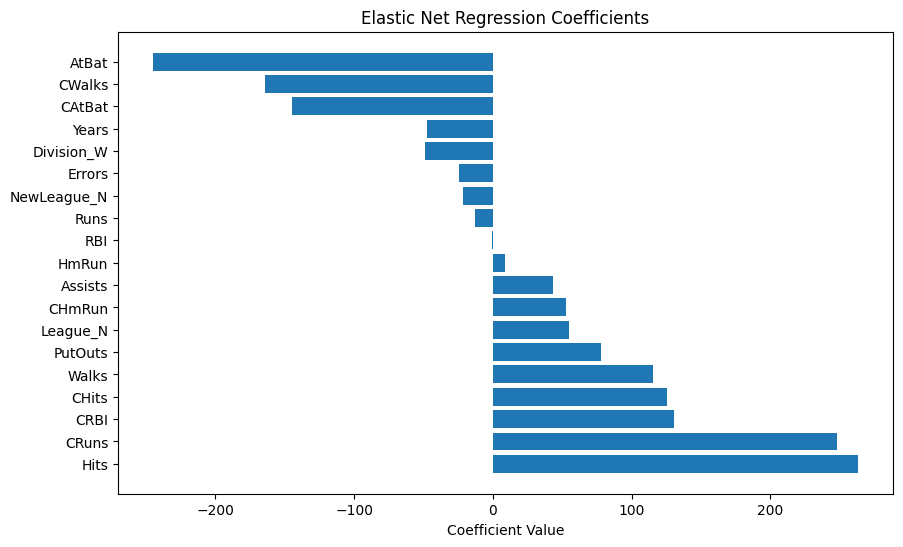

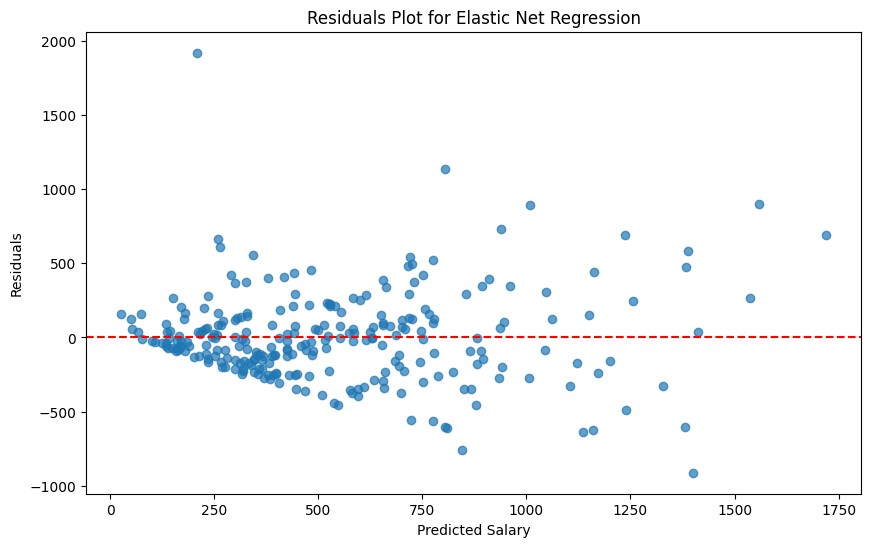

In [43]:
X = df.drop(columns=['Salary'])
y = df['Salary']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['League', 'Division', 'NewLeague']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet(max_iter=10000))
])

param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'elasticnet__l1_ratio': [0.2, 0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['elasticnet__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet__l1_ratio']

elastic_net_pipeline.set_params(elasticnet__alpha=best_alpha, elasticnet__l1_ratio=best_l1_ratio)
elastic_net_pipeline.fit(X, y)

cross_val_mse = -cross_val_score(elastic_net_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_cross_val_mse = cross_val_mse.mean()
coefs = elastic_net_pipeline.named_steps['elasticnet'].coef_

feature_names = numeric_features + list(
    elastic_net_pipeline.named_steps['preprocessor']
    .transformers_[1][1].get_feature_names_out(categorical_features)
)

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

plt.figure(figsize=(10, 6))
coefs_df = coefs_df.sort_values(by='Coefficient', ascending=False)
plt.barh(coefs_df['Feature'], coefs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Elastic Net Regression Coefficients')
plt.show()

y_pred = elastic_net_pipeline.predict(X)

residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Elastic Net Regression')
plt.show()


Using the pipeline from before on all the variables to predict salary using ElasticNet method, we can see that it fits better for the lower salaries. There are a couple outliers, and the variability increases as the salary increases.